## BSL

This notebook demonstrates how to use the BSL methods version available [here](https://github.com/uremes/elfi/tree/update_bsl). Based on the tutorial available [here](https://github.com/RyanJafefKelly/notebooks/blob/bsl_notebooks/bsl.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import elfi

seed = 1
np.random.seed(seed)

In [2]:
from elfi.methods.bsl import pdf_methods, pre_sample_methods

Load MA(2) model:

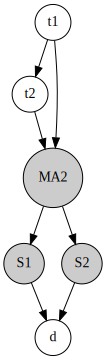

In [3]:
from elfi.examples import ma2
m = ma2.get_model(n_obs=50, seed_obs=seed)
elfi.draw(m)

The BSL version demonstrated in this notebook does not use a synthetic likelihood node, but the process is otherwise the same as discussed in the tutorial notebook. First task is to choose or define how the observed and simulated data are converted to approximate likelihood scores.

- likelihood function

The likelihood function is expected to use observed and simulated features to calculate an estimate for the log-likelihood that the same parameter values produced the observed and simulated features. 

Here we choose the standard synthetic likelihood estimation method. This method approximates the simulated feature distribution with a multivariate normal distribution.

In [4]:
likelihood = pdf_methods.bsl_likelihood()

- feature nodes

Features used in likelihood calculation must be included as observable nodes in the ELFI model. Observable nodes in our MA(2) model include the simulator node `MA2` and the summaries `S1` and `S2`. To match examples used in the BSL literature, we do not summarise the observed or simulated data but estimate the synthetic likelihood based on observed and simulated data. 

In [5]:
feature_names = 'MA2'

The functions that let us examine the selected features and assess relevant feature properties are now collected in their own module. This means that we do not need to decide on a likelihood function or create a sampler to use `plot_covariance_matrix` or `plot_features`.

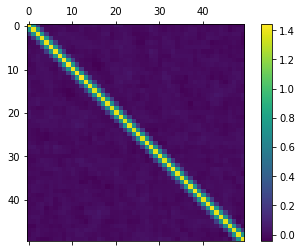

In [6]:
params = {'t1': 0.6, 't2': 0.2}
nsim = 10000
pre_sample_methods.plot_covariance_matrix(m, params, nsim, feature_names)

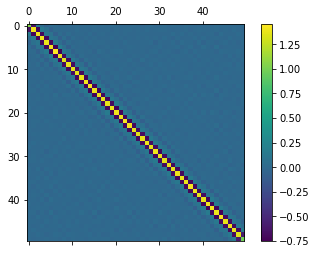

In [7]:
pre_sample_methods.plot_covariance_matrix(m, params, nsim, feature_names, precision=True)

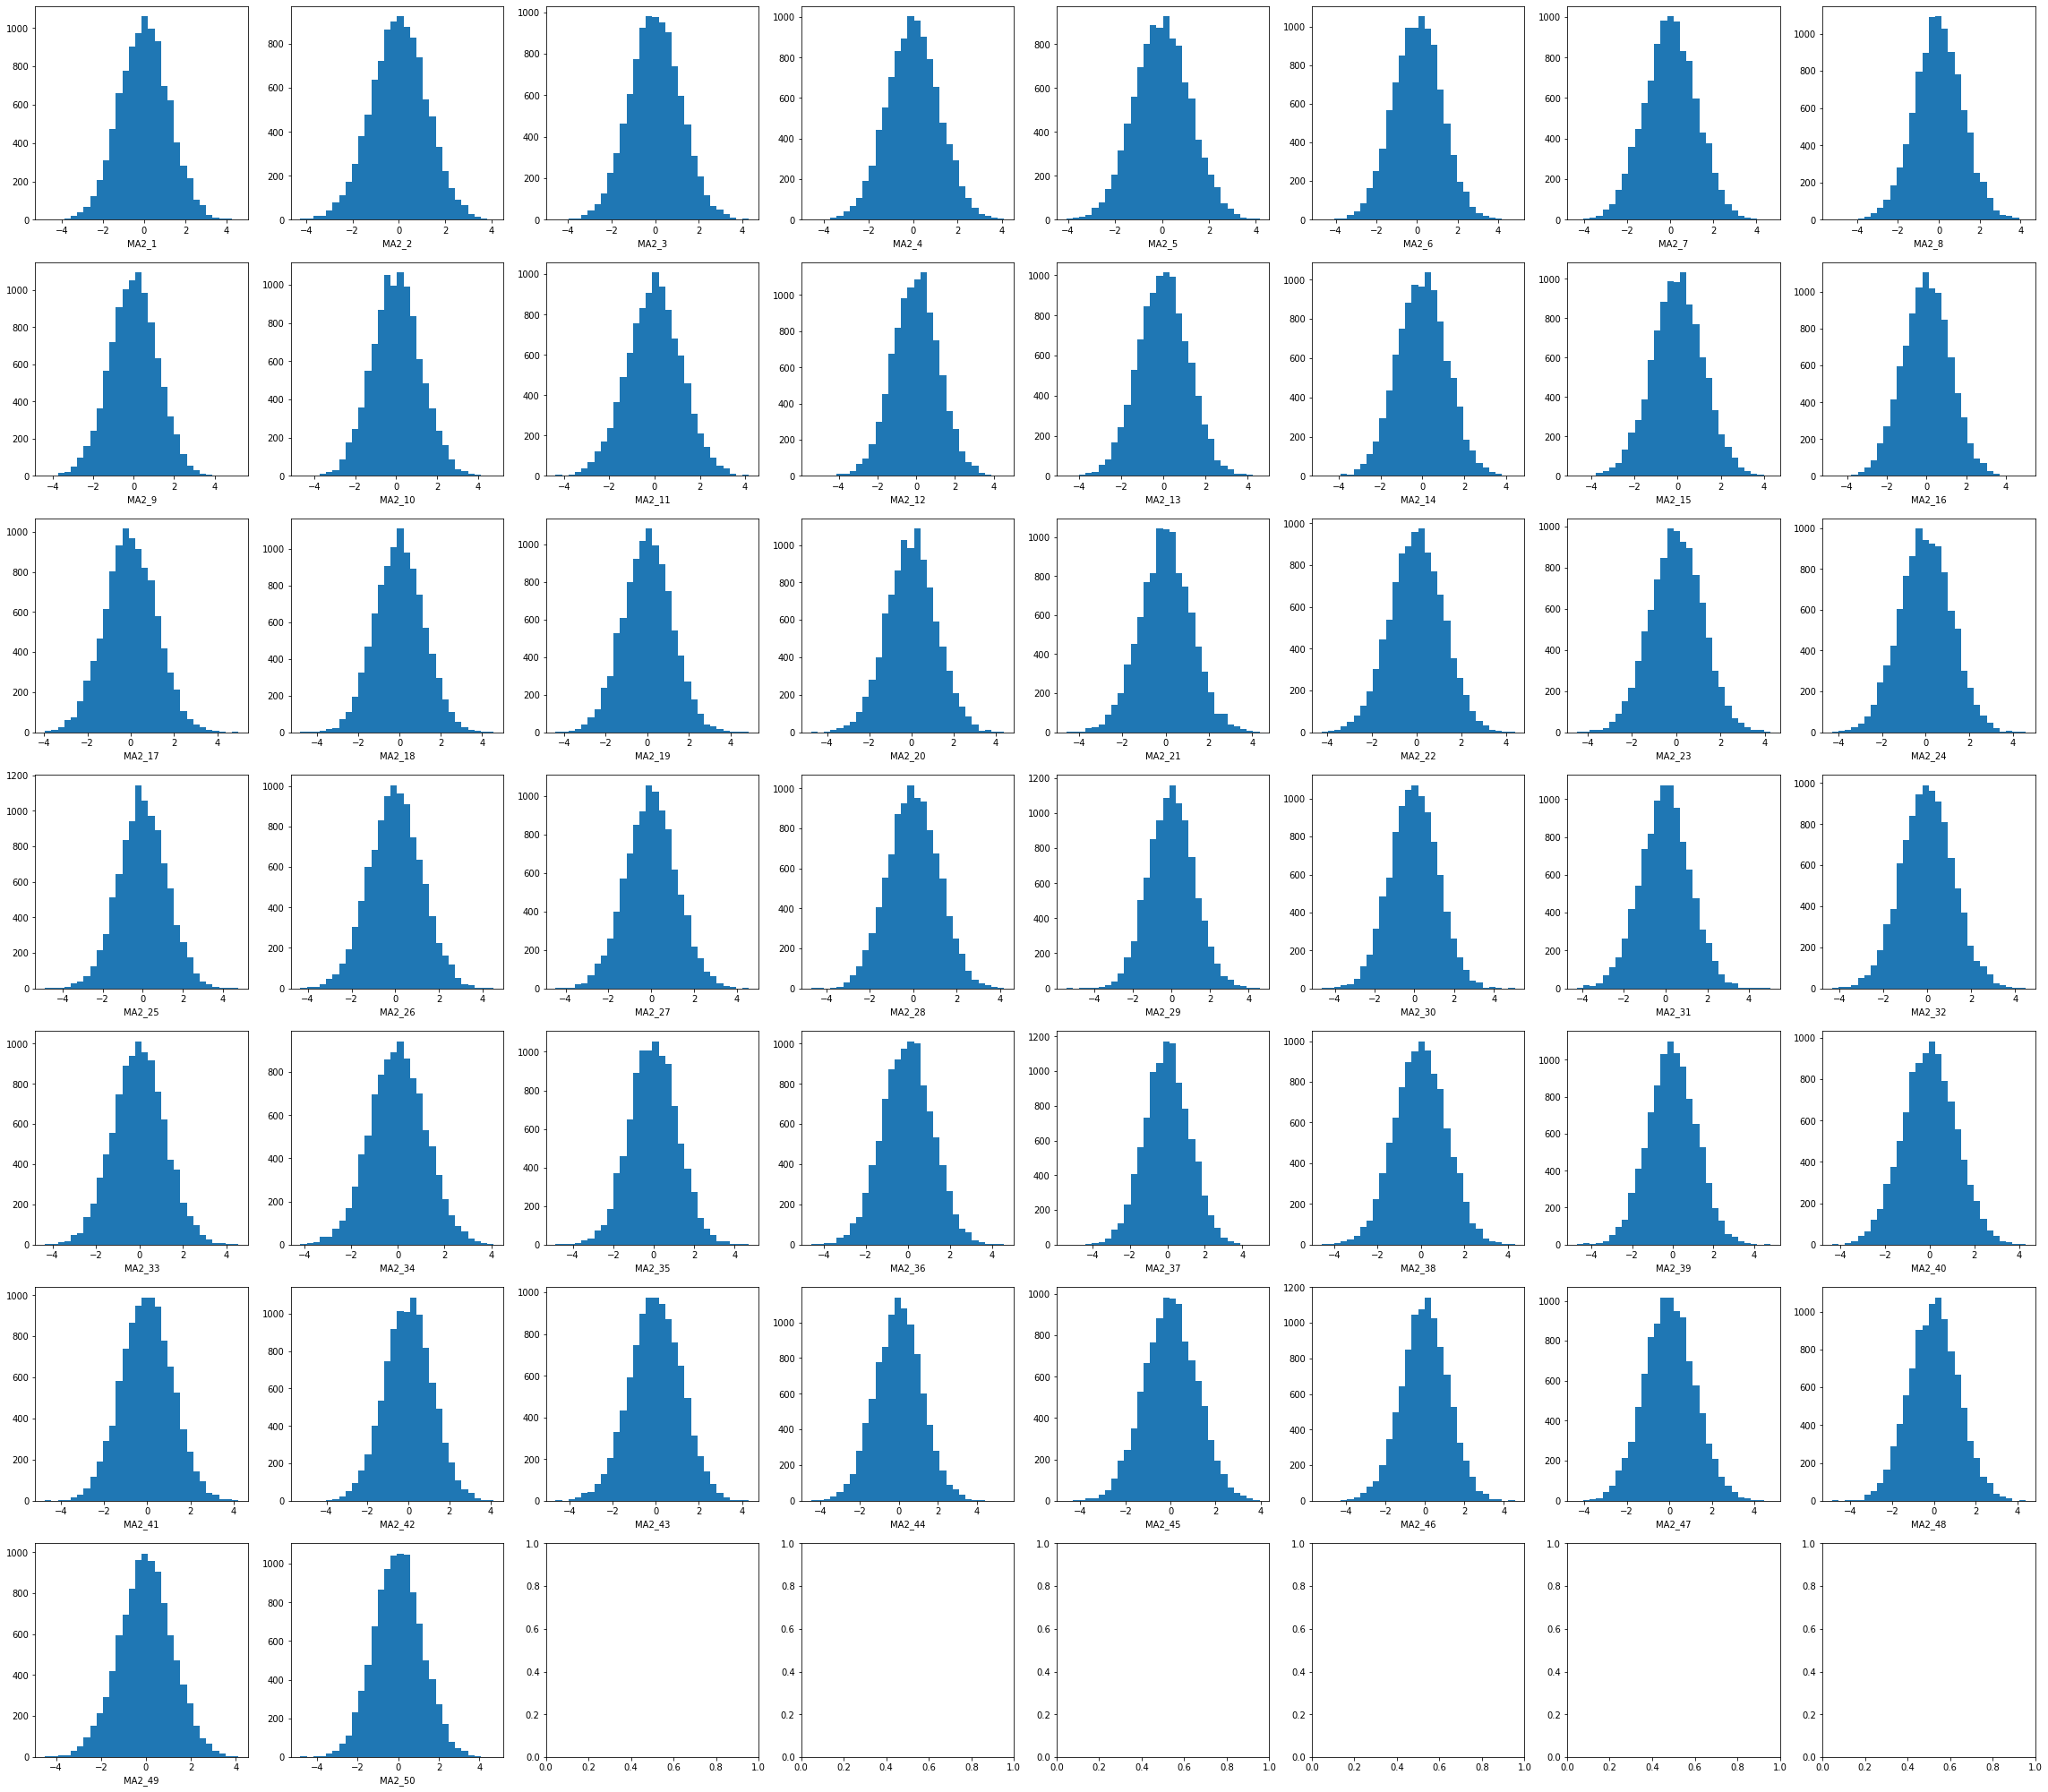

In [8]:
pre_sample_methods.plot_features(m, params, nsim, feature_names)

- simulation count

The synthetic likelihood scores are calculated based on the observed features and a parametric distribution model estimated based on `nsim_round` simulated features. `nsim_round` should be selected so that the standard deviation between log-likelihood scores is between 1 and 2.

In [9]:
nsim_round = 500
std_value = pre_sample_methods.log_SL_stdev(m, params, nsim_round, feature_names, likelihood=likelihood, M=100)
std_value

1.7301899697792167

Now we have decided how the likelihood scores are calculated and can create a `BSL` instance to sample the approximate posterior distribution estimated based on the selected likelihood scores.

In [10]:
standard_bsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

We can see here that `feature_names` and `likelihood` are optional parameters. `feature_names` defaults to all summary nodes in model `m` and `likelihood` defaults to the standard synthetic likelihood estimation method.

Additional parameters include `batch_size` which in this version has the same meaning as in other ELFI inference methods. However while most methods have default batch size 1, the default batch size here is the simulation count `nsim_round`.

To proceed, we call `sample` to set the sampler parameters and sample a chain from the approximate posterior distribution. Unless robust BSL is used, the `sample` function takes the same parameters as in the previous BSL version. Required parameters include the sample size and a covariance matrix for the proposal distribution.

Here we also set the initial parameter values `params0`.

In [11]:
mcmc_iterations = 2000
est_post_cov = np.array([[0.02, 0.01], [0.01, 0.02]])
params0 = [0.6, 0.2]
res = standard_bsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [12]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.219
Parameter                Mean               2.5%              97.5%
t1:                     0.426              0.142              0.740
t2:                     0.234             -0.044              0.467


There are no changes in the results class.

In [13]:
res.compute_ess()

{'t1': 69.85051011126637, 't2': 86.11215292286599}

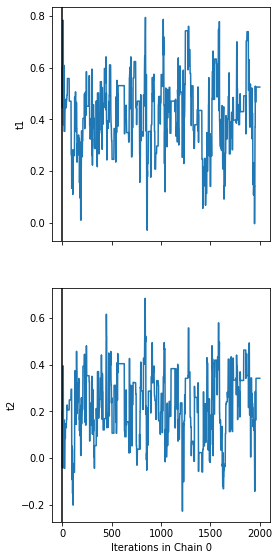

In [14]:
res.plot_traces();

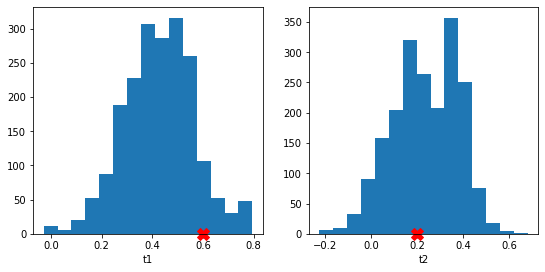

In [15]:
mbins = 15
res.plot_marginals(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

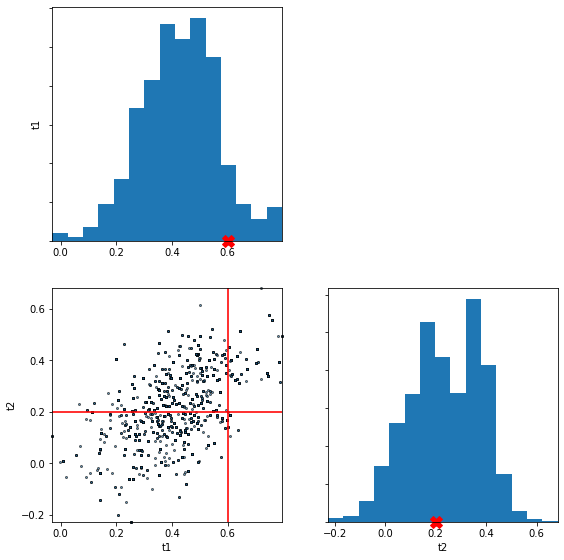

In [16]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

This concludes the standard BSL example. Extensions to the standard method are implemented as extensions to the likelihood function or as alternative likelihood functions.

## BSLasso

BSLasso substitutes the sample covariance matrix calculated based on the simulated features with a sparse estimate. This should let us reduce the simulation count without an increase in the standard deviation between log-likelihood scores. 

We must set `shrinkage='glasso'` in the likelihood function and choose the regularisation parameter for the penalised covariance estimator. We can use `select_penalty` to choose the parameter value.

In [17]:
from elfi.methods.bsl.select_penalty import select_penalty

In [18]:
likelihood = pdf_methods.bsl_likelihood()
shrinkage = 'glasso'
sigma = 1.5
nsim = [100, 300, 500]
penalty, std_value = select_penalty(m, nsim, params, feature_names, sigma=sigma, shrinkage=shrinkage, likelihood=likelihood)

In [19]:
std_value

array([1.51916662, 1.49011017, 1.47564814])

In [20]:
penalty

array([0.0450492 , 0.00909528, 0.00408677])

Update `nsim_round` and the likelihood function.

In [21]:
nsim_round = nsim[1]
likelihood = pdf_methods.bsl_likelihood(shrinkage=shrinkage, penalty=penalty[1])

Test:

In [22]:
bslasso = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [23]:
res = bslasso.sample(mcmc_iterations, est_post_cov, params0=params0)

 /Users/umremes/opt/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning:graphical_lasso: did not converge after 200 iteration: dual gap: 3.671e-03


Progress [==================================================] 100.0% Complete


In [24]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.202
Parameter                Mean               2.5%              97.5%
t1:                     0.440              0.092              0.818
t2:                     0.247             -0.066              0.616


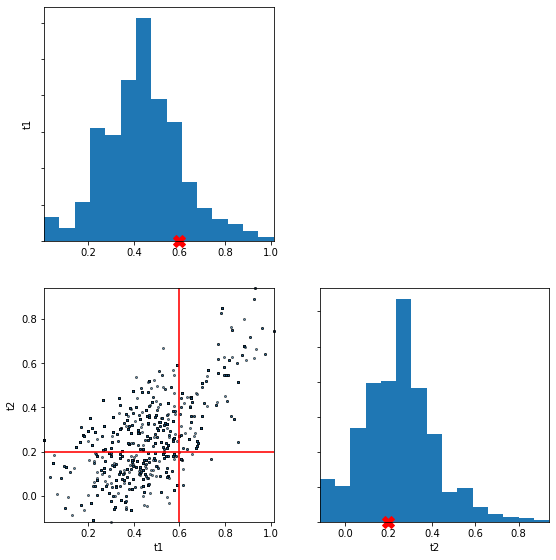

In [25]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

## wBSL

We should be able to reduce the simulation count even more if the features calculated based on observed and simulated data are whitened.

In [26]:
from elfi.methods.bsl.estimate_whitening_matrix import estimate_whitening_matrix

In [27]:
likelihood_type = 'bsl'
nsim = 20000
W = estimate_whitening_matrix(m, nsim, params, feature_names, likelihood_type=likelihood_type)

In [28]:
likelihood = pdf_methods.bsl_likelihood()
shrinkage = 'warton'
sigma = 1.5
nsim = [100, 300]
penalty, std_value = select_penalty(m, nsim, params, feature_names, whitening=W, sigma=sigma, shrinkage=shrinkage, likelihood=likelihood)

In [29]:
std_value

array([1.51373566, 1.06239808])

In [30]:
penalty

array([0.48, 0.8 ])

Update `nsim_round` and the likelihood function.

In [31]:
nsim_round = nsim[0]
likelihood = pdf_methods.bsl_likelihood(whitening=W, shrinkage=shrinkage, penalty=penalty[0])

Test:

In [32]:
wbsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [33]:
res = wbsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [34]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.129
Parameter                Mean               2.5%              97.5%
t1:                     0.424              0.136              0.723
t2:                     0.226             -0.094              0.521


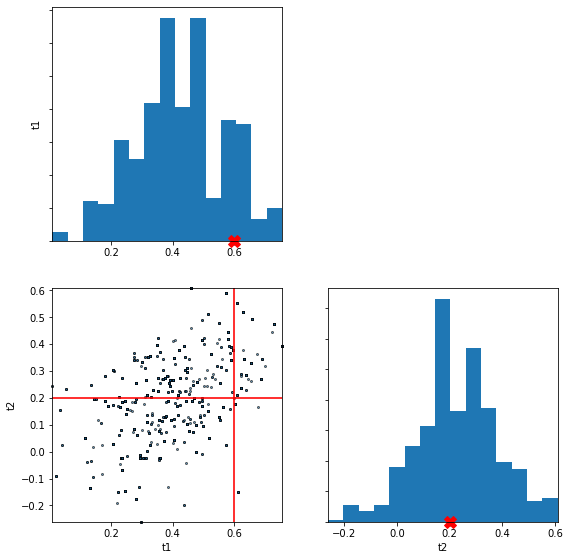

In [35]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

## SemiBSL

The previous examples all used `bsl_likelihood` which models the simulated feature distribution as multivariate normal. Alternatives include the semi-parametric synthetic likelihood.

In [36]:
likelihood = pdf_methods.semibsl_likelihood()

Test:

In [37]:
nsim_round = 500
semibsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [38]:
res = semibsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [39]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.254
Parameter                Mean               2.5%              97.5%
t1:                     0.410              0.141              0.705
t2:                     0.213             -0.043              0.499


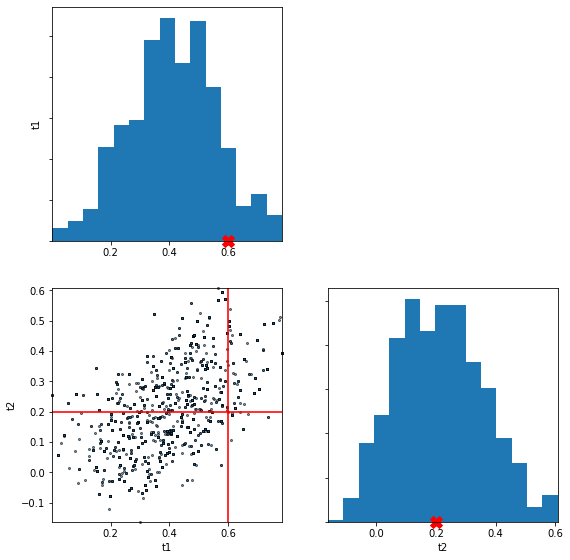

In [40]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

## R-BSL

Robust BSL uses a misspecified likelihood function with mean or variance adjustment, and samples both the simulator parameters which are `t1` and `t2` in this example and adjustment parameters `gamma`.

Let us start with mean adjustment:

In [41]:
likelihood = pdf_methods.misspec_likelihood("mean")

The tutorial notebook used R-BSL with the same features as other methods, but here we use the summary statistics since this makes the results easier to check.

In [42]:
feature_names = ['S1', 'S2']

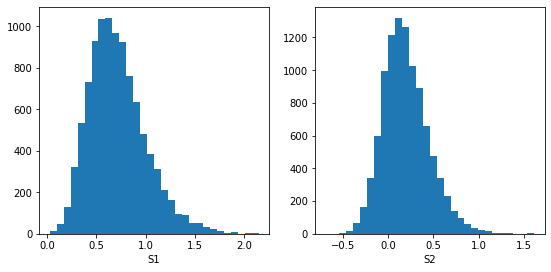

In [43]:
nsim = 10000
pre_sample_methods.plot_features(m, params, nsim, feature_names)

Initialise the method as usual:

In [44]:
nsim_round = 500
rbsl_m = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

R-BSL uses a slice sampler for the `gamma` parameters, and `sample` is now used to set both the MCMC and slice sampler parameters. Here we use the default values for `w` and `max_iter` but set the prior distribution scale `tau` to a smaller value to indicate that we do not believe that likelihood is misspecified.

In [45]:
res = rbsl_m.sample(mcmc_iterations, est_post_cov, params0=params0, tau=0.1)

Progress [==================================================] 100.0% Complete


In [46]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.658
Parameter                Mean               2.5%              97.5%
t1:                     0.383             -0.022              0.820
t2:                     0.219             -0.226              0.935


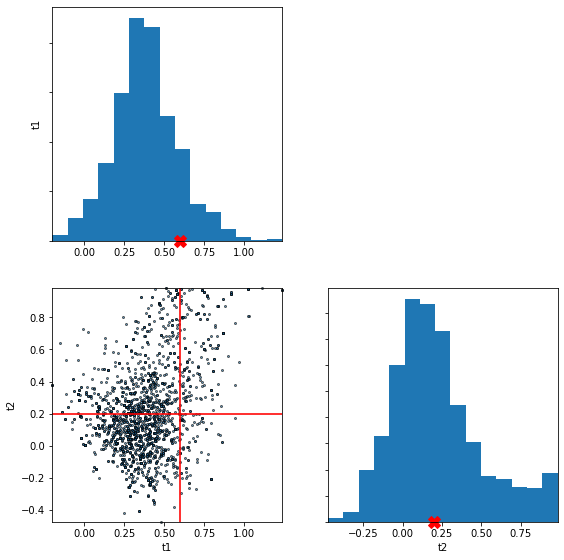

In [47]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

We can also visualise the sampled `gamma` parameters.

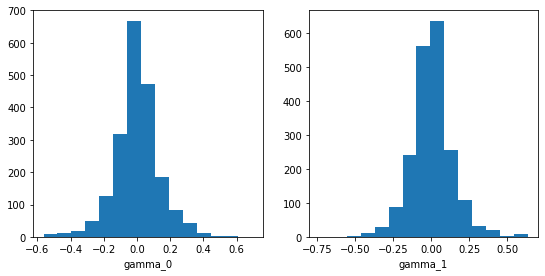

In [48]:
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_m.observed.size)], np.transpose(res.outputs['gamma'])))
elfi.visualization.visualization.plot_summaries(gamma_dict, bins=mbins);

The same with variance adjustment:

In [49]:
likelihood = pdf_methods.misspec_likelihood("variance")

In [50]:
rbsl_v = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [51]:
res = rbsl_v.sample(mcmc_iterations, est_post_cov, params0=params0, tau=0.1)

Progress [==================================================] 100.0% Complete


In [52]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.675
Parameter                Mean               2.5%              97.5%
t1:                     0.412              0.007              0.888
t2:                     0.166             -0.356              0.778


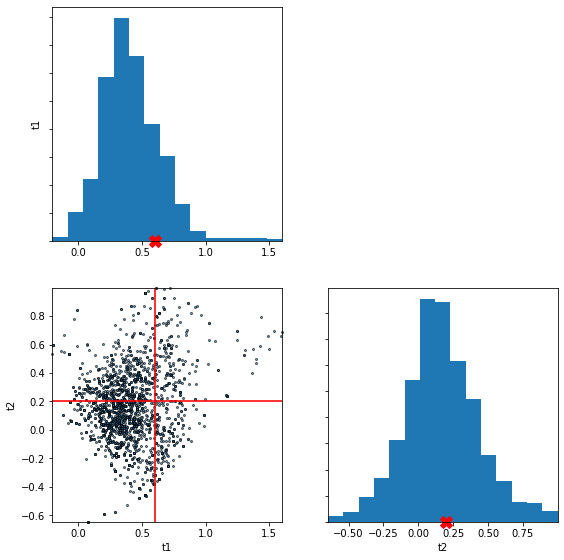

In [53]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

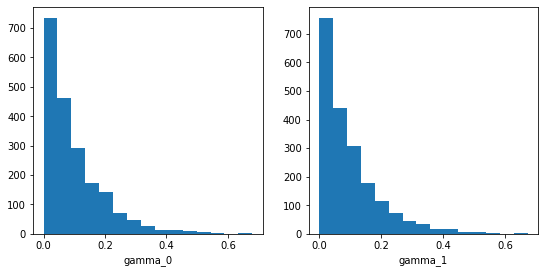

In [54]:
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_v.observed.size)], np.transpose(res.outputs['gamma'])))
elfi.visualization.visualization.plot_summaries(gamma_dict, bins=mbins);

## Parallelising simulations

To parallelise the simulated feature generation in this BSL version, we can choose a batch size that is smaller than the simulation count and let an appropriate ELFI client run batches in parallel. In addition the option to parallellise the simulator node with `parallellise=True` remains available.

In [55]:
elfi.set_client('multiprocessing')
bsl = elfi.BSL(m, 200, batch_size=50, seed=seed)
res = bsl.sample(mcmc_iterations, est_post_cov, bar=False)